### Урок 5. Случайный лес

Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

(На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
from matplotlib.colors import ListedColormap
from sklearn import model_selection

In [6]:
class Tree:
    """Класс дерева"""
    def __init__(self, features, labels, max_depth = None, criterion='gini'):
        self.max_depth = max_depth
        self._criterion = criterion
        self.nodes = self.build(features, labels)
    def _split(self, data, labels, index, t):
        """
        Разбиение датасета в узле.
        :param data:
        :param labels:
        :param index:
        :param t:
        :return:
        """
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def _gini(self, labels):
        """
        Расчёт критерия Джини
        :param labels:
        :return:
        """
        #  подсчёт количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчёт критерия
        impurity = 1  # "impurity" - "нечистота", степень неопределённости
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity

    def _entropy(self, labels):
        """
        Расччёт энтропии
        :param labels:
        :return:
        """
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p) if p != 0 else 0
        return impurity

    def _crit(self, labels):
        """Критерий качества"""
        if self._criterion == 'gini':
            return self._gini(labels)
        elif self._criterion == 'entropy':
            return self._entropy(labels)
        return 0

    def _quality(self, left_labels, right_labels, current_gini):
        """
        Расчёт качества
        :param left_labels:
        :param right_labels:
        :param current_gini:
        :return:
        """
        # доля выборки, ушедшей в левое поддерево
        p = float(left_labels.shape[0]) / (
                    left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self._crit(left_labels) - (1 - p) * self._crit(
            right_labels)

    def _best_split(self, data, labels):
        """
        Нахождение наилучшего разбиения.
        :param data:
        :param labels:
        :return:
        """
        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_criteria = self._crit(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = [row[index] for row in data]

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, где в узле остаётся менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels,
                                          current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def _build(self, features, labels):
        """
        Построение дерева посредством рекурсивной функции.
        :param data: Массив данных
        :param labels: Массив классов
        :param max_depth: Критерий остановки по максимальной глубине дерева
        :return:
        """
        quality, t, index = self._best_split(features, labels)

        stop_criteria = quality == 0  # Базовый случай — прекращаем рекурсию, когда нет прироста в качества
        if self.max_depth is not None:  # Если установлен критерий по макс. глубине
            stop_criteria |= self.max_depth == 0

        if stop_criteria:
            return Leaf(features, labels)

        true_data, false_data, true_labels, false_labels = self._split(features, labels, index, t)
        # Рекурсивно строим две ветки
        true_branch = self._build(true_data, true_labels) if len(np.unique(true_labels)) > 1 else Leaf(true_data, true_labels)
        false_branch = self._build(false_data, false_labels) if len(np.unique(false_labels)) > 1 else Leaf(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def build(self, features, labels):
        """Построение дерева"""
        return self._build(features, labels)

    def _predict_row(self, features, node):
        if isinstance(node, Leaf):
            return node.predict()
        return self._predict_row(features, node.next(features))

    def predict(self, features):
        return [self._predict_row(row, self.nodes) for row in features]

class Node:
    """Класс узла дерева."""
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

    def next(self, data):
        """Получение следующего узла дерева."""
        return self.true_branch if data[self.index] <= self.t else self.false_branch

class Leaf:
    """Класс листа дерева"""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его
        prediction = max(classes, key=classes.get)
        return prediction

class RandomForest:
    """Случайный лес."""
    def __init__(self, trees_count:int=1, max_depth:int=None, random_state=42, criterion='gini'):
        """
        Конструктор.
        :param trees_count: int, default=1
            Количество деревьев
        :param max_depth: int, default=1
            Максимальная глубина дереве
        :param random_state: int, default=42
        :param criterion: {"gini", "entropy"}, default="gini"
            Критерий оценки качетва
        :param oob_score: bool, default=False
            Использовать out-of-bag
        """
        self.trees = []
        self.trees_count = trees_count
        self.max_depth = max_depth
        self.oob_score_ = 0
        self._criterion=criterion
        self._random_state = random_state


    def fit(self, features, labels):
        """Обучение."""
        bootstrap = self._get_bootstrap(features, labels)
        oob_pred = np.zeros((features.shape[0], len(set(labels))))
        for X, y, oob in bootstrap:
            current_tree = Tree(X, y, max_depth=self.max_depth,
                     criterion=self._criterion)

            tmp_oob_pred = current_tree.predict(features[oob])
            for i in range(len(oob)):
                oob_pred[oob[i], tmp_oob_pred[i]] += 1

            self.trees.append(current_tree)

        self.oob_score_ = self.accuracy(labels, np.argmax(oob_pred, axis=1))

    def accuracy(self, y, y_pred):
        correct = 0
        for i in range(len(y)):
            if y[i] == y_pred[i]:
                correct += 1
        return correct / float(len(y))

    def _get_bootstrap(self, features, labels):
        """Генерация."""
        n_samples = features.shape[0]
        bootstrap = []

        for i in range(self.trees_count):
            sample_index = np.random.randint(0, n_samples, size=n_samples)
            b_data = features[sample_index]
            b_labels = labels[sample_index]
            oob = np.setdiff1d(np.arange(n_samples), sample_index)

            bootstrap.append((b_data, b_labels, oob))
        return bootstrap

    def predict(self, features):
        """Предсказание."""
        predictions = [ t.predict(features) for t in self.trees]
        zipped_predictions = list(zip(*predictions))
        return [max(set(_), key=_.count) for _ in zipped_predictions]



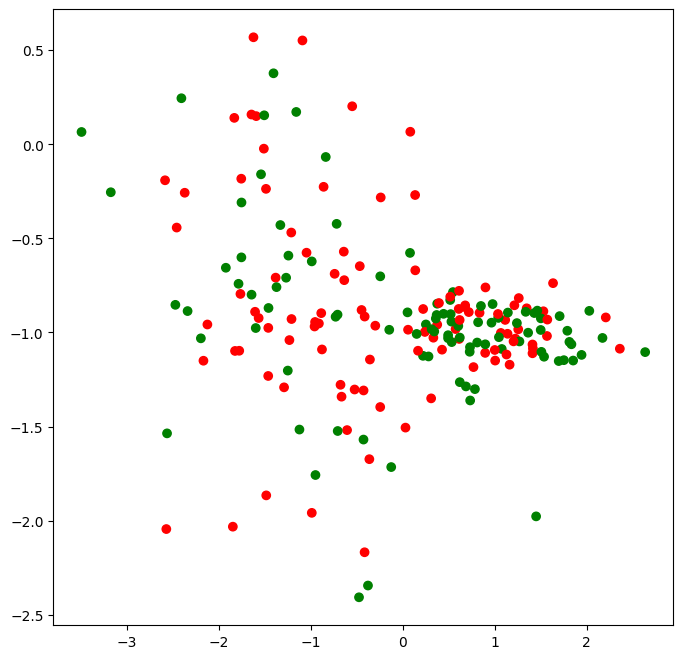

In [69]:
# генерация данных
classification_data, classification_labels = make_classification(
    n_samples=200,n_features=2,n_informative=2,n_classes=2,n_redundant=0,n_clusters_per_class=1,flip_y=0.75,
    random_state=12
)
# рахбиение
train_data, test_data, train_labels, test_labels = train_test_split(
    classification_data, classification_labels, test_size=0.3, random_state=41
)

# Визуализация
colors = ListedColormap(['red', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)

In [15]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

Случайный лес из 1 деревьев
	Точность (train): 0.6857142857142857
	Точность (test): 0.55


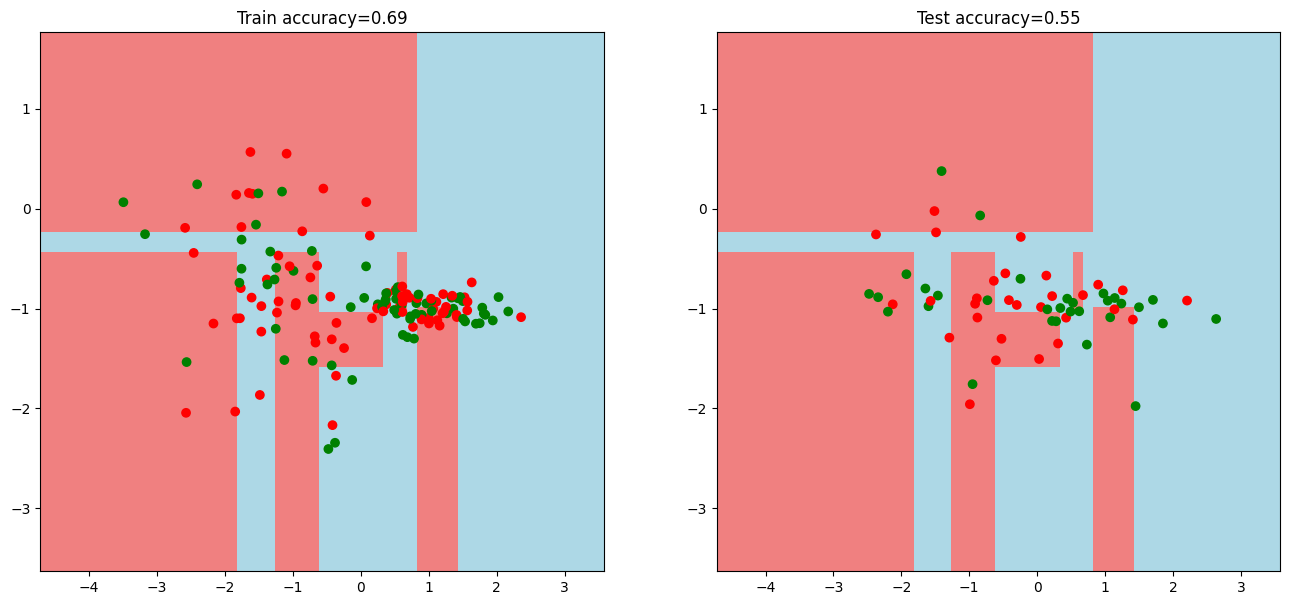

Случайный лес из 3 деревьев
	Точность (train): 0.75
	Точность (test): 0.45


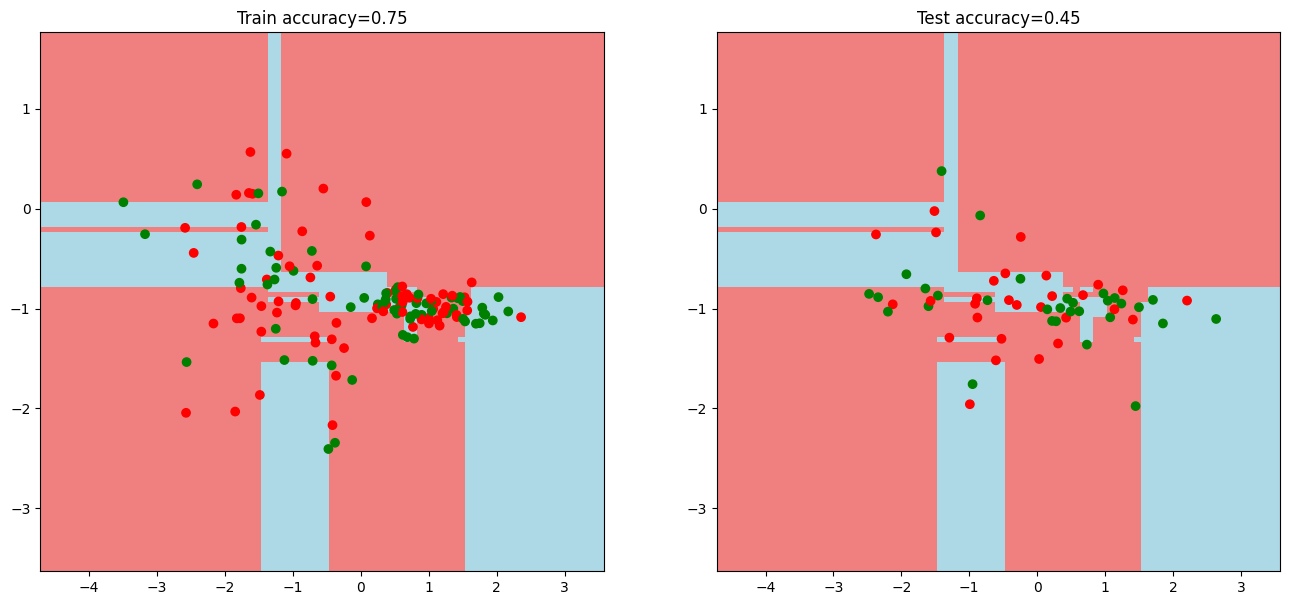

Случайный лес из 10 деревьев
	Точность (train): 0.7785714285714286
	Точность (test): 0.5166666666666667


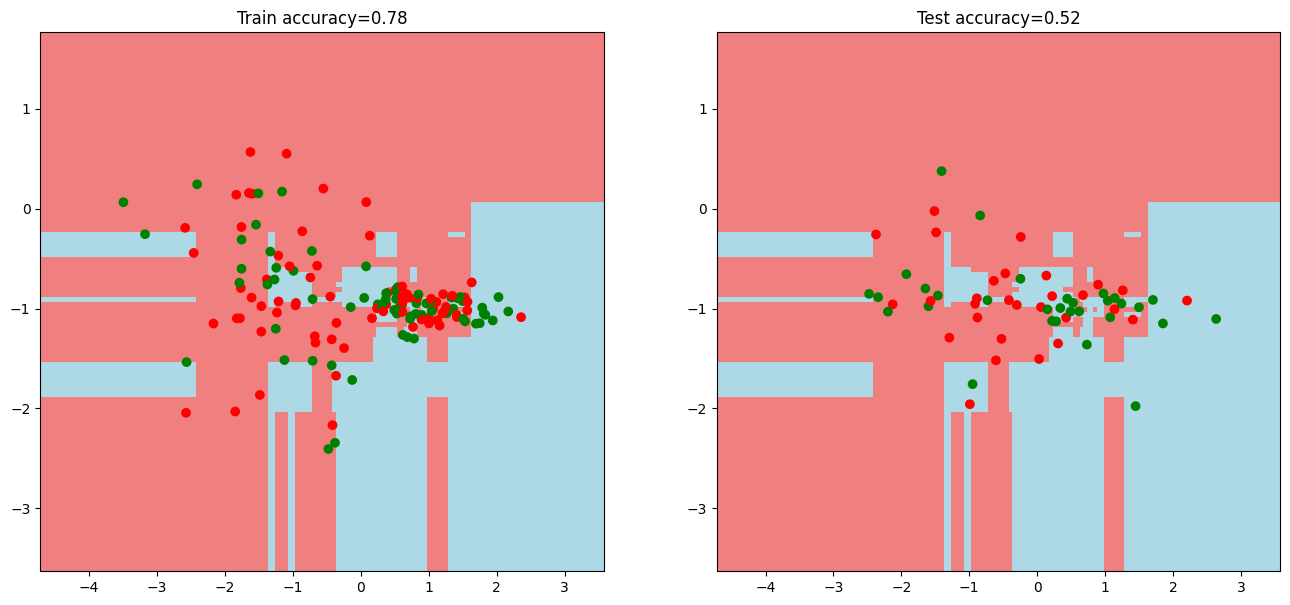

Случайный лес из 50 деревьев
	Точность (train): 0.8571428571428571
	Точность (test): 0.5333333333333333


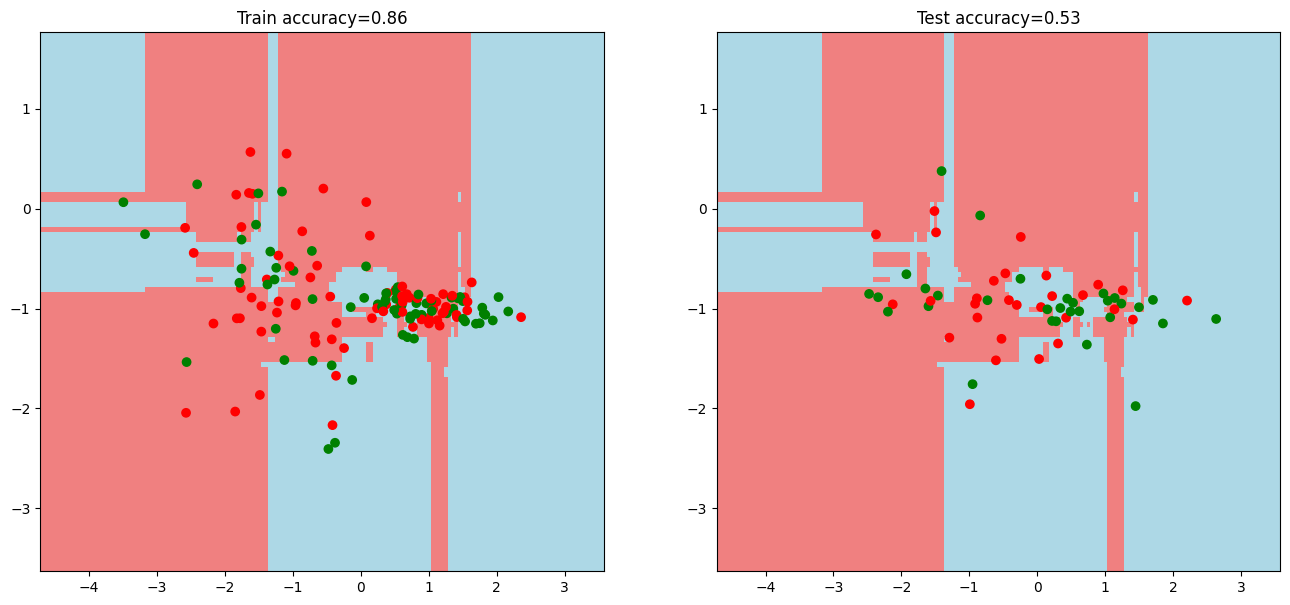

Случайный лес из 100 деревьев
	Точность (train): 0.9071428571428571
	Точность (test): 0.55


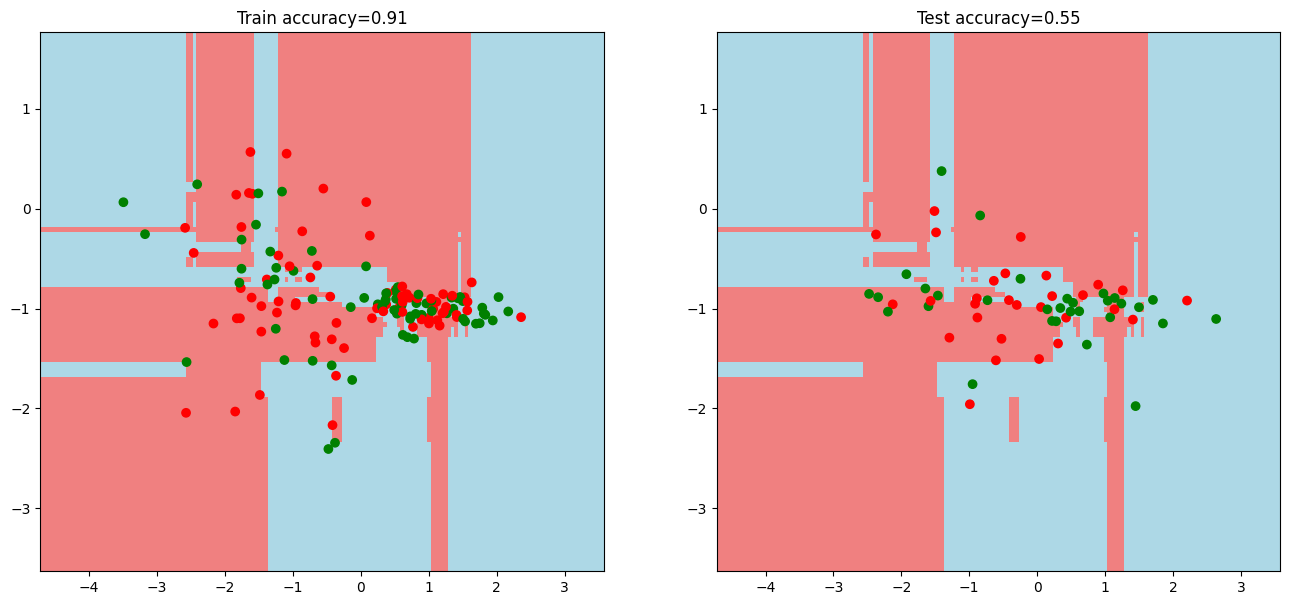

In [71]:
accuracy_graph_train = []
accuracy_graph_test = []
for trees_cnt in [1,3,10,50, 100]:
    print(f'Случайный лес из {trees_cnt} деревьев')
    rf = RandomForest(trees_cnt)
    rf.fit(train_data, train_labels)
    train_pred = rf.predict(train_data)
    test_pred = rf.predict(test_data)

    train_accuracy = rf.accuracy(train_labels, train_pred)
    test_accuracy = rf.accuracy(test_labels, test_pred)
    print('\tТочность (train):',train_accuracy)
    print('\tТочность (test):',test_accuracy)

    accuracy_graph_train.append((trees_cnt, train_accuracy))
    accuracy_graph_test.append((trees_cnt, test_accuracy))

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(rf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap =colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()


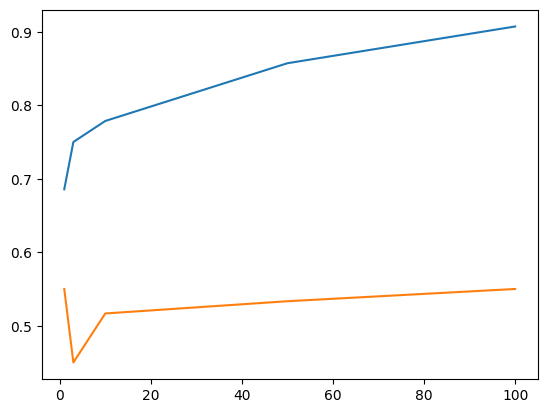

In [73]:
plt.plot([_[0] for _ in accuracy_graph_train], [_[1] for _ in accuracy_graph_train])
plt.plot([_[0] for _ in accuracy_graph_test], [_[1] for _ in accuracy_graph_test])

Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

По данной выборке выводы сделать сложно, видно что на тренировочной выборке растёт качество, а на тестовой такого явного прироста не наблюдается, значит модель переобучается

---

Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.
(На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

Всё необходимое реализованно в клаасах выше. Поменяем критерий и посмотрим как всё изменится

Случайный лес из 1 деревьев
	OOB: 0.5
	Точность (train): 0.7
	Точность (test): 0.5333333333333333


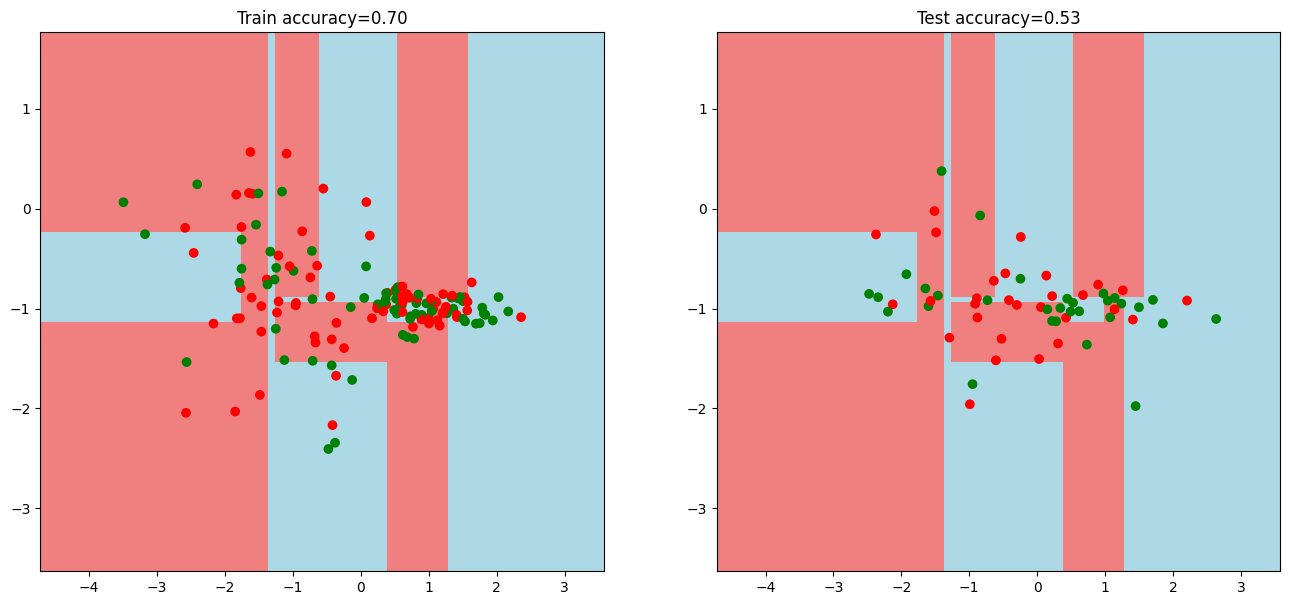

Случайный лес из 3 деревьев
	OOB: 0.5214285714285715
	Точность (train): 0.7071428571428572
	Точность (test): 0.4


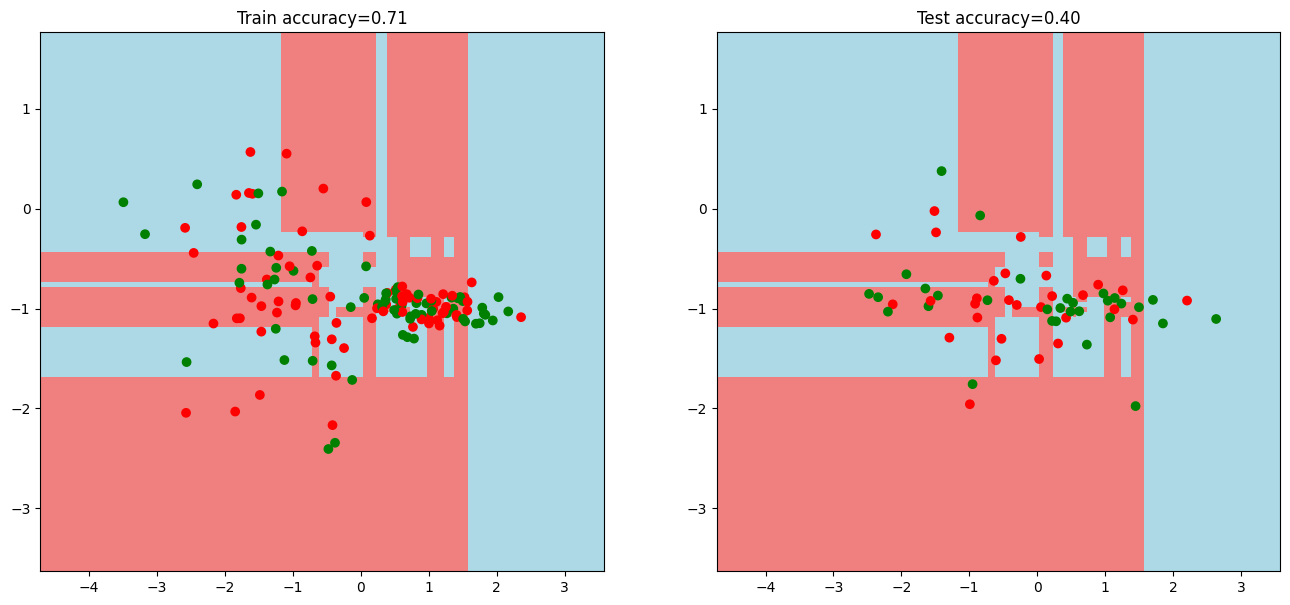

Случайный лес из 10 деревьев
	OOB: 0.4642857142857143
	Точность (train): 0.8214285714285714
	Точность (test): 0.5833333333333334


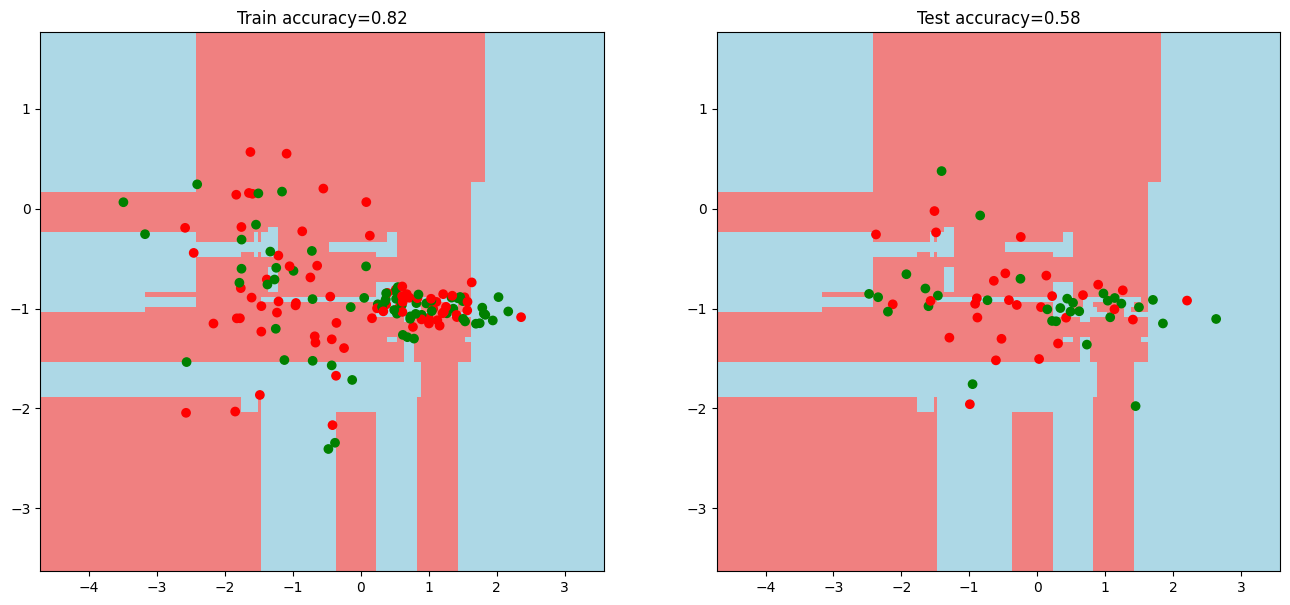

Случайный лес из 50 деревьев
	OOB: 0.4714285714285714
	Точность (train): 0.8714285714285714
	Точность (test): 0.6


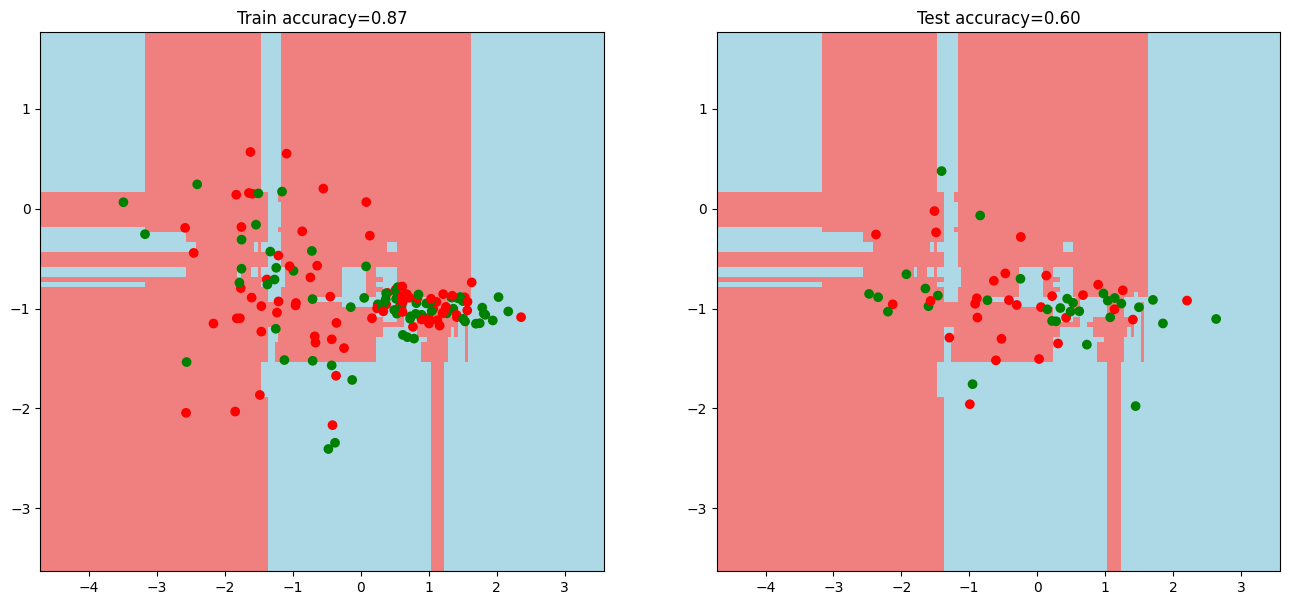

Случайный лес из 100 деревьев
	OOB: 0.4857142857142857
	Точность (train): 0.8928571428571429
	Точность (test): 0.55


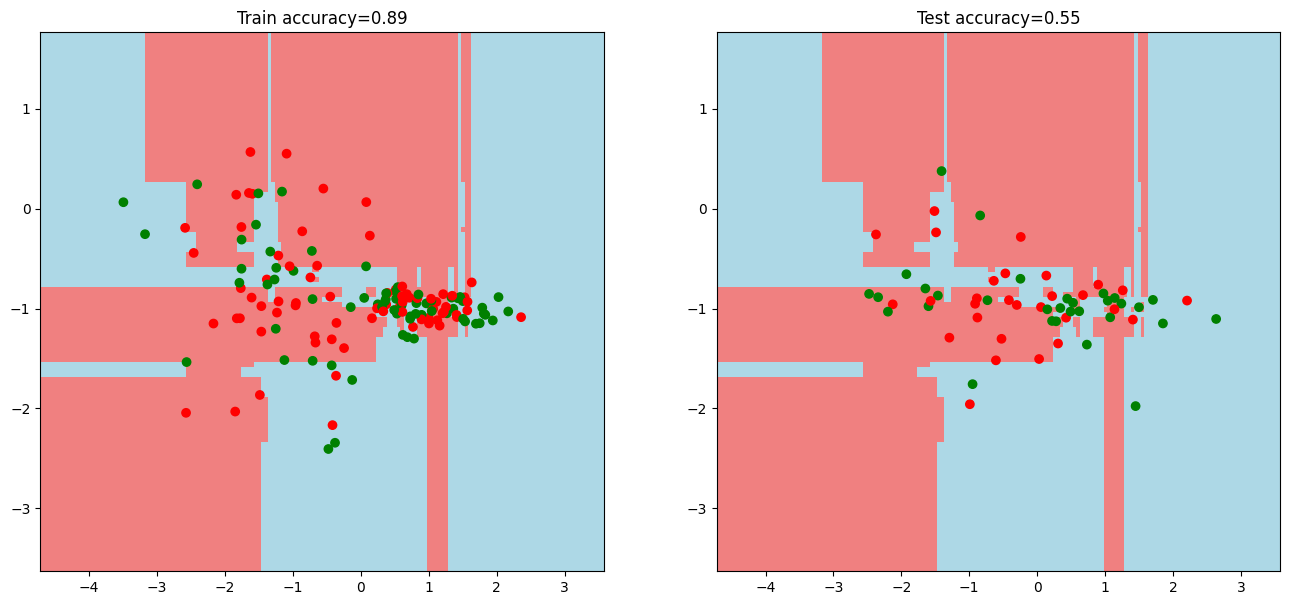

In [75]:
accuracy_graph_train = []
accuracy_graph_test = []
for trees_cnt in [1,3,10,50, 100]:
    print(f'Случайный лес из {trees_cnt} деревьев')
    rf = RandomForest(trees_cnt, criterion='entropy')
    rf.fit(train_data, train_labels)
    train_pred = rf.predict(train_data)
    test_pred = rf.predict(test_data)

    train_accuracy = rf.accuracy(train_labels, train_pred)
    test_accuracy = rf.accuracy(test_labels, test_pred)
    print('\tOOB:',rf.oob_score_)
    print('\tТочность (train):',train_accuracy)
    print('\tТочность (test):',test_accuracy)

    accuracy_graph_train.append((trees_cnt, train_accuracy))
    accuracy_graph_test.append((trees_cnt, test_accuracy))

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(rf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap =colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()
